In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..\\scripts\\")
import test
sys.path.insert(0, "..\\scripts\\")
import taxis_analysis_function as MyFn
import matplotlib.pyplot as plt


if "__main__" == __name__:
    df = MyFn.load_dataset()
    
    distance_profit_analysis = (df.pipe(MyFn.distance_group_column)
    .pipe(MyFn.calculate_work_hours)
    .pipe(MyFn.calculate_gasoline_consumption)
    .pipe(MyFn.calculate_auto_utilization)
    .pipe(MyFn.group_by_distance)
    .pipe(MyFn.calculate_total_profit)
    .pipe(MyFn.calculate_profit_by_hour)
    )

In [2]:
distance_profit_analysis

,distance_group,count_summons,dist_avg,dist_total,dist_min,dist_max,fare,tips,tolls,gas_expense,auto_utilization_cost,hours_sum,total,profit_per_hour
0,short,5422,1.723670,9345.74,0.01,5.0,50551.21,8513.38,48.50,654.2018,2009.3341,999.317222,56352.5541,56.391057
1,medium,776,8.504639,6599.60,5.01,15.0,22360.92,2877.87,1192.32,461.9720,1418.9140,390.609167,22165.5840,56.746195
2,long,184,19.087065,3512.02,15.01,36.7,10258.54,1211.74,819.14,245.8414,755.0843,146.400278,9650.2143,65.916639


Hypotesis: Passengers leave more tips when paying in cash than card

result: Does not leave a tip in cash

Calculate corelation beetwen tips and distance

In [26]:
df = MyFn.load_dataset()
df = MyFn.filtered_by_date(df, date_range=('2019-02-28','2019-03-31'))
#2019-02-28
#2019-03-31
general_dataframe = (df.pipe(MyFn.add_week_day)
.pipe(MyFn.get_time_groups)
.pipe(MyFn.group_by_time_weekdays)
.pipe(MyFn.calculate_passengers_fare_index)
)

In [24]:
MyFn.visualisation(general_dataframe, by = 'passengers', visual=False)

3h_interval,00-03,03-06,06-09,09-12,12-15,15-18,18-21,21-24
week_day,,,,,,,,
Monday,22,11,151,158,148,203,221,148
Tuesday,31,27,133,192,212,201,247,163
Wednesday,49,15,166,258,255,225,291,161
Thursday,72,26,148,179,189,218,282,173
Friday,123,50,211,202,221,257,289,188
Saturday,195,59,89,256,288,252,306,138
Sunday,138,76,78,171,189,168,157,81


<AxesSubplot:title={'center':'by_passengers'}, xlabel='3h_interval', ylabel='week_day'>

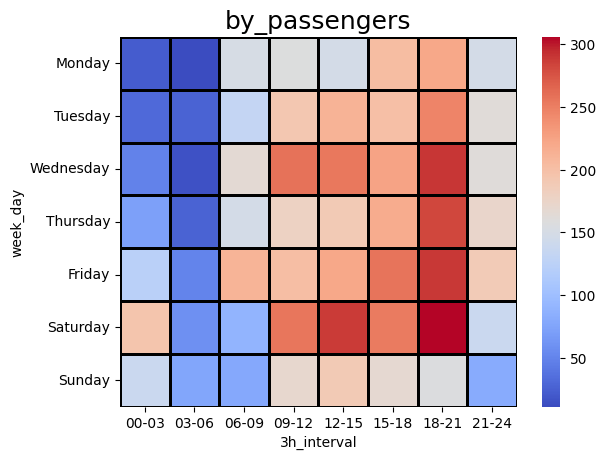

In [33]:
MyFn.visualisation(general_dataframe, by = 'passengers', visual=True)